# Exrcise 22: Galaxy vs quasar with deep learning

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do you best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard) (but don't start learning about it now, it takes a while to get it up and running).

---

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import corner

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve,precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score

from astroML.utils import pickle_results

import pandas as pd
from IPython.display import display

%config InlineBackend.figure_format='retina'

## Prepare Data

In [9]:
file = '../solutions/galaxyquasar.csv'
data_csv = np.genfromtxt(file, delimiter=',', usecols=(0,1,2,3,4,5), dtype = str)
print(data_csv)

[['u' 'g' 'r' 'i' 'z' 'class']
 ['18.97213' '18.53676' '18.5828' '18.34936' '18.29215' 'QSO']
 ['19.24592' '17.47646' '16.47817' '16.04472' '15.68851' 'GALAXY']
 ...
 ['18.62718' '17.30876' '16.87371' '16.62399' '16.42296' 'GALAXY']
 ['19.5514' '18.27711' '17.62101' '17.21947' '17.03347' 'GALAXY']
 ['18.80772' '17.75751' '17.405' '17.2165' '17.12295' 'GALAXY']]


In [10]:
lab = np.char.replace(data_csv[1:,5], 'GALAXY', '0')
lab = np.char.replace(lab, 'QSO', '1').astype(int)

ug = data_csv[1:,0].astype(float) - data_csv[1:,1].astype(float)
gr = data_csv[1:,1].astype(float) - data_csv[1:,2].astype(float)
ri = data_csv[1:,2].astype(float) - data_csv[1:,3].astype(float)
iz = data_csv[1:,3].astype(float) - data_csv[1:,4].astype(float)

data = np.column_stack((ug,gr,ri,iz))

galaxies = data[: , :4][lab==1].astype(float)
quasars = data[: , :4][lab==0].astype(float)

names = ['u-g', 'g-r', 'r-i', 'i-z']

First we check the distribution of the features

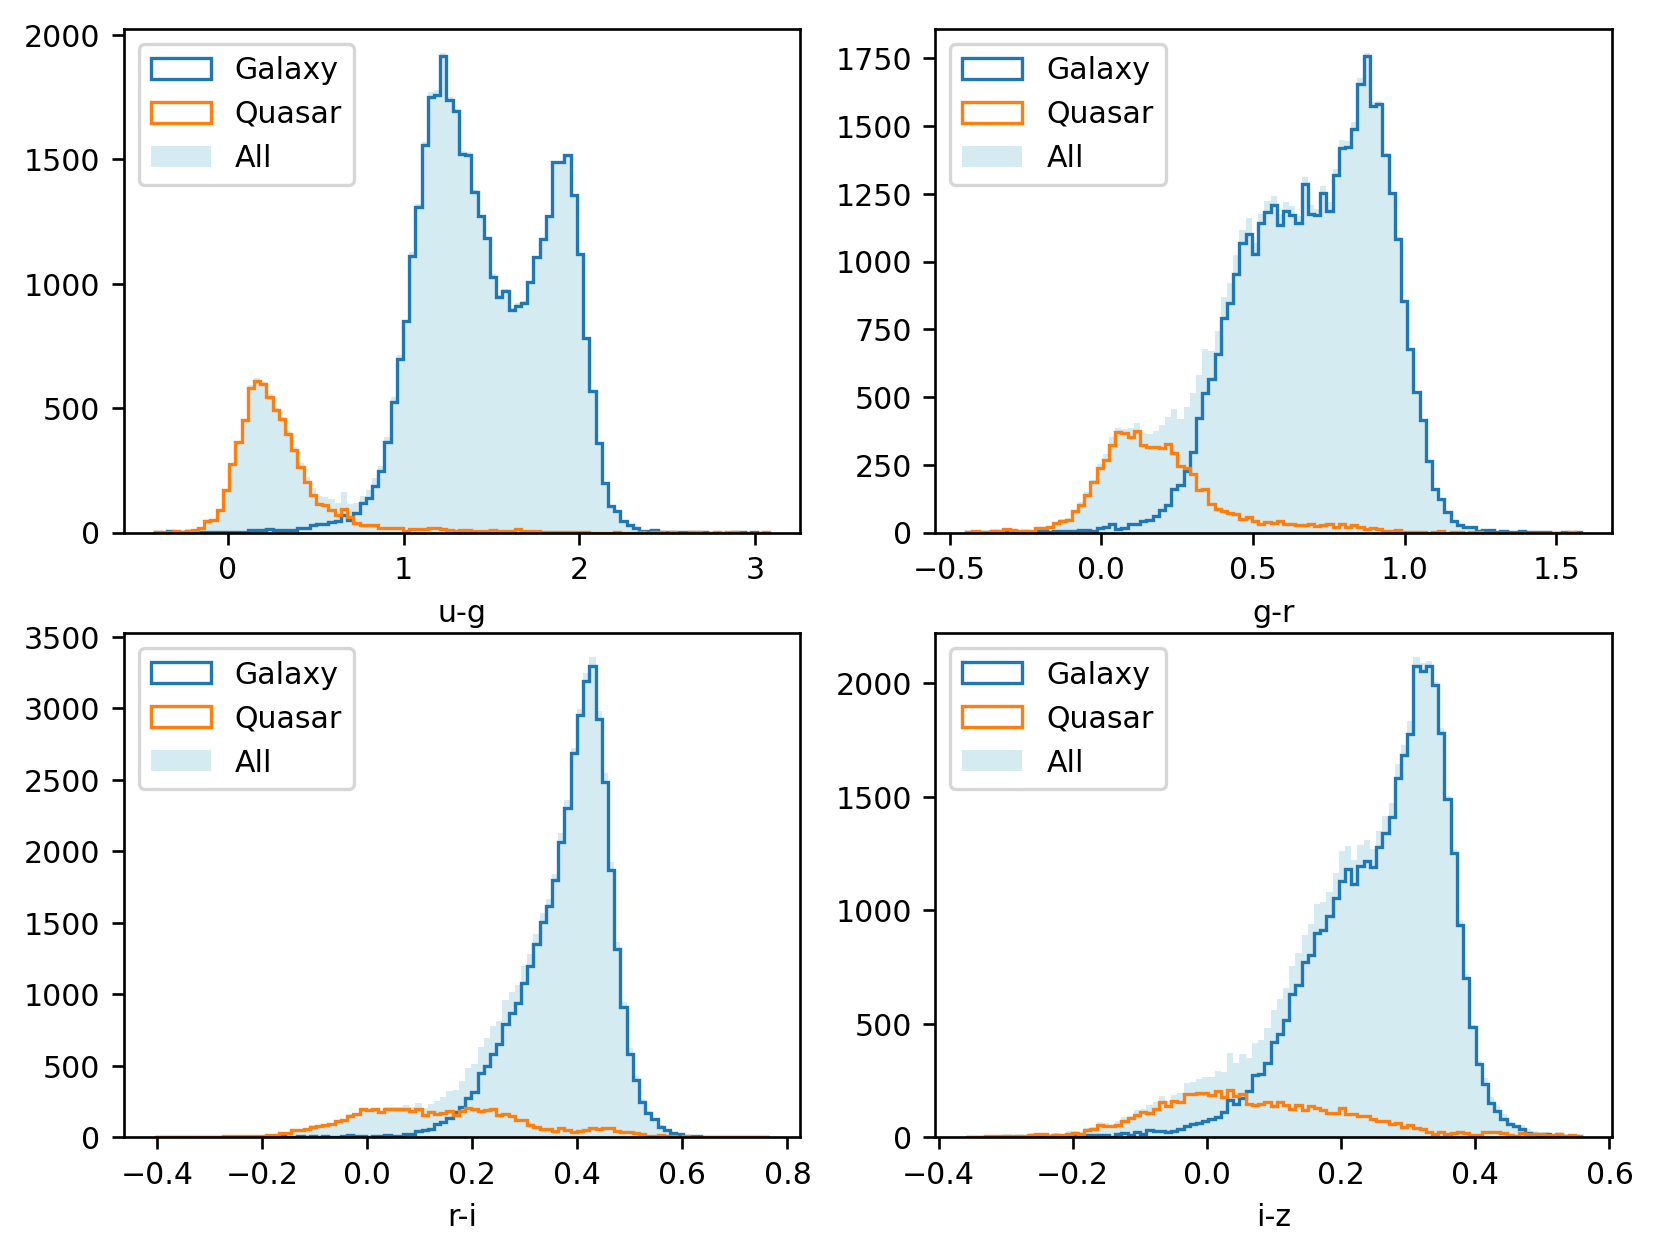

In [11]:
#-------  Plt params  ----------------
plt.rc('figure', figsize=(8,6), dpi=120)
plt.rcParams.update({'font.size': 9})
#--------------------------------------------

fig, axs = plt.subplots(2,2)

# bins = 'auto'
quant_list = [(0.0005, 0.9995),(0.001, 0.9995),(0.001, 0.999),(0.003, 0.997)] # Got boundaries by eye
bounds = []

for ax,color, name, quant in zip(axs.flatten() ,data[:,:4].T,names, quant_list):
    
    min, max = np.quantile(color, quant)
    bounds.append([min,max])
    bins = np.linspace(min, max, 100)   
    gala = color[lab==0]
    quas = color[lab==1]
    ax.hist(gala, bins=bins, histtype = 'step', label = 'Galaxy', lw=1)
    ax.hist(quas, bins=bins, histtype = 'step', label = 'Quasar', lw=1)
    ax.hist(color, bins=bins, label = 'All', color='lightblue', alpha=0.5,)
    ax.legend()
    ax.set_xlabel(name)
    # ax.set_yscale('log')
    
plt.tight_layout;

From color distributions it seems that u-g is by far the most informative feature as it shows a clear bimodality differentiating galaxies and quasars. For the other colors, quasars only create a small bump in the total distribution.

In the above histograms we choose x axes boundaries using data quantiles to exclude outliers and look at bulk distributions for each color. 

Checking histograms including all data we see that there are some outliers: we trim them from the data sample.


In [12]:
# Remove outliers
bounds = np.array(bounds)
data_t = data.T

# mask on transposed data matrix
mask1 = np.array([np.logical_and(bounds[i,0] < data.T[i], data.T[i] < bounds[i,1]) for i in [0,1,2,3]])
mask2 = np.all(mask1,axis=0)

data_clean = data[mask2,:]
lab_clean = lab[mask2]

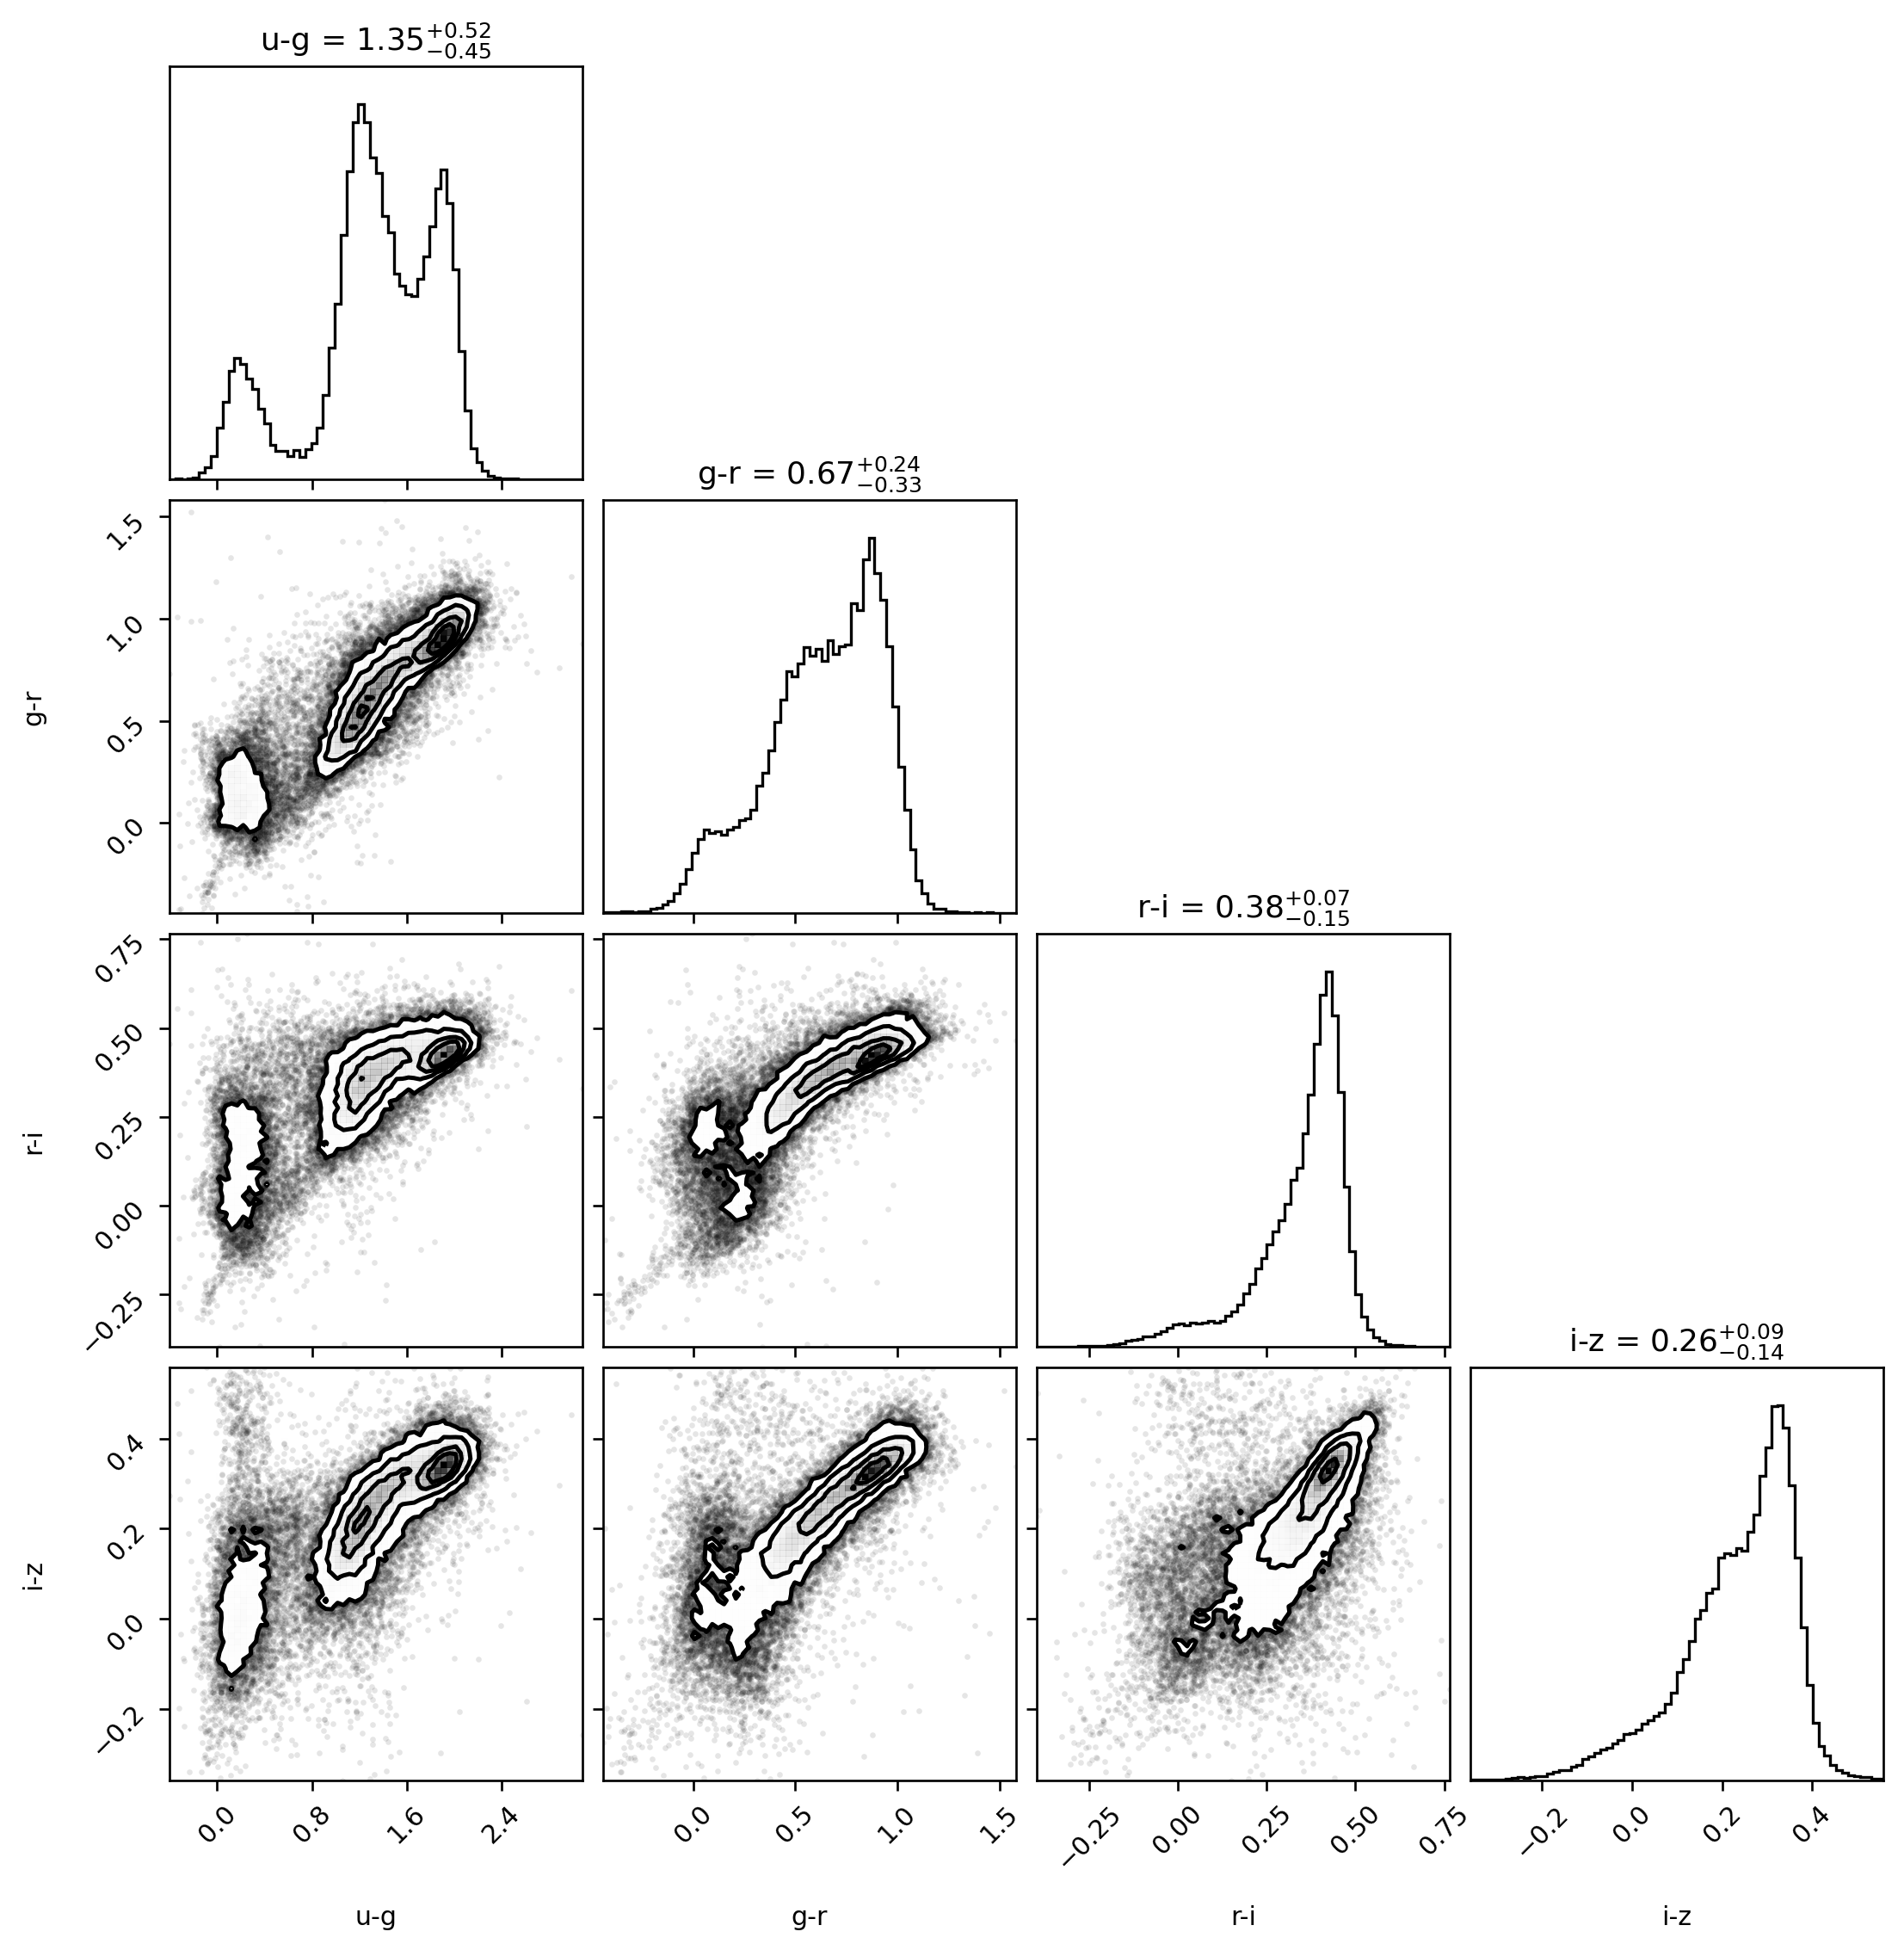

In [13]:
corner.corner(data_clean, labels = names, bins=70, show_titles=True);

In [14]:
# Train and test sets
X = data_clean
y = lab_clean

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.3, random_state=0)

# Scaling data after split to avoid information leakage from test 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Neural Networks

In [54]:
def run_classifier(clf, name):
    '''
    Input: clf(sklearn classifier object), name(str)
    Output: list of "info" containing a list of [metrics, curves], clf params, clf input name
    '''
    
    clf.fit(X_train, y_train)
    
    y_probs = clf.predict_proba(X_test)[:, 1]
    y_pred = clf.predict(X_test)
    
    complet = recall_score(y_test, y_pred)
    contam = 1 - precision_score(y_test, y_pred)
    accur = accuracy_score(y_test, y_pred)
    
    metrics = np.array([accur, complet, contam])
    
    fpr, tpr, thresh = roc_curve(y_test, y_probs)
    precision, recall, thresh2 = precision_recall_curve(y_test, y_probs)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    
    curves = [[fpr,tpr],[precision,recall]]
    
    results = [metrics, curves]
    params = clf.get_params()
    
    info = [results, params, name]
    return  info

# To compare classifiers evaluated beforehand
def compare_classifiers(info_list, plot_curves = True, plot_metrics_bars = True ):
    ''' 
    Input: list of outputs from run_classifier()
    Output: metrics pd.DataFrame, list of params of the classifiers
    '''
    results_list = [info[0] for info in info_list]
    params_list = [info[1] for info in info_list]
    names = [info[2] for info in info_list]

    metrics_arr = np.array([results[0] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot_curves == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(8,4), dpi=120)
        plt.rcParams.update({'font.size': 9})
        #--------------------------------------------
        
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.set_xlim(0, 0.04)
        ax1.set_ylim(0, 1.02)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0.2, 1.02);
        
    if plot_metrics_bars == True:
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(10,5), dpi=120)
        plt.rcParams.update({'font.size': 12})
        #--------------------------------------------

        labels = ['Accuracy', 'Completeness', 'Contamination']
        x = np.array([1,3,5])  # the label locations
        width = 0.25  # the width of the bars

        fig, ax = plt.subplots(1,1)

        i = 0
        for metric,name in zip(metrics_arr,names):
            rects = ax.bar(x+width*i, metric, width, label=name)
            ax.bar_label(rects, padding=3, fmt='%.3f', fontsize=8)
            i += 1

        ax.set_ylabel('Scores')
        ax.set_title('Metrics')
        ax.set_xticks(x+2.5*width, labels)

        ax.legend(loc='center right', fontsize=12)

        fig.tight_layout()
        
            
    return metrics_dataframe, params_list

# To do everything in one go (not used)
def evaluate_classifiers(classifiers_d, plot = True): 
    '''
    Input: dictionary{'Classifier_name': clf_obj, ...}
    Output: metrics pd.DataFrame and list of classifier params
    If plot = True (default) plots ROC and precision-recall curves
    '''
    clf_list = classifiers_d.values()
    names = classifiers_d.keys()
    # #####
    # names = ['MLP', 'MLP']
    # clf_list = [mlp_base,mlp_base]
    # plot = True
    # #####

    results_list = []
    params_list = []
    
    for clf in clf_list:
        results = run_classifier(clf)
        params = clf.get_params()
        params_list.append(params)
        results_list.append(results)  # list of results from different classifiers

    metrics_arr = np.array([results[0] for results in results_list]).T
    keys = ['name', 'accuracy', 'completeness', 'contamination']
    metrics_d = dict(zip(keys,[names, *metrics_arr]))
    
    metrics_dataframe = pd.DataFrame(metrics_d).sort_values("accuracy", ascending=False)
    display(metrics_dataframe)
    
    if plot == True:
        
        #-------  Plt params  ----------------
        plt.rc('figure', figsize=(8,4), dpi=120)
        plt.rcParams.update({'font.size': 9})
        #--------------------------------------------
        
        fig = plt.figure()
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        for results,name  in zip(results_list,names):
            curves = results[1]
            roc = curves[0]
            prec_rec = curves[1]
            ax1.plot(roc[0],roc[1], label=name)
            ax2.plot(prec_rec[0], prec_rec[1], label=name)
            
        ax1.set_xlabel('false positive rate')
        ax1.set_ylabel('true positive rate')
        ax1.set_title('ROC curves')
        ax1.legend(loc=4)
        ax1.set_xlim(0, 0.04)
        ax1.set_ylim(0, 1.02)
        ax2.set_xlabel('precision')
        ax2.set_ylabel('recall')
        ax2.set_title('Precision - Recall curves')
        ax2.set_xlim(0, 1.0)
        ax2.set_ylim(0.2, 1.02);
        
            
    return metrics_dataframe, params_list


In [82]:
# Define classifier
layers = (5,)
mlp_base = MLPClassifier(
                    hidden_layer_sizes=layers,
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate='constant', 
                    learning_rate_init=0.001, 
                    random_state=404)

layers = (5,5)
mlp_2layers = MLPClassifier(
                    hidden_layer_sizes=layers,
                    solver='adam', 
                    activation = 'relu', 
                    learning_rate='constant', 
                    learning_rate_init=0.001, 
                    random_state=404)

classifiers_d = {'MLP base':mlp_base, 'MLP 2 layers':mlp_2layers}

names = ['MLP base', 'MLP 2 layers']


,name,accuracy,completeness,contamination
1,MLP 2 layers,0.987038,0.944736,0.037379
0,MLP base,0.986635,0.939019,0.034770


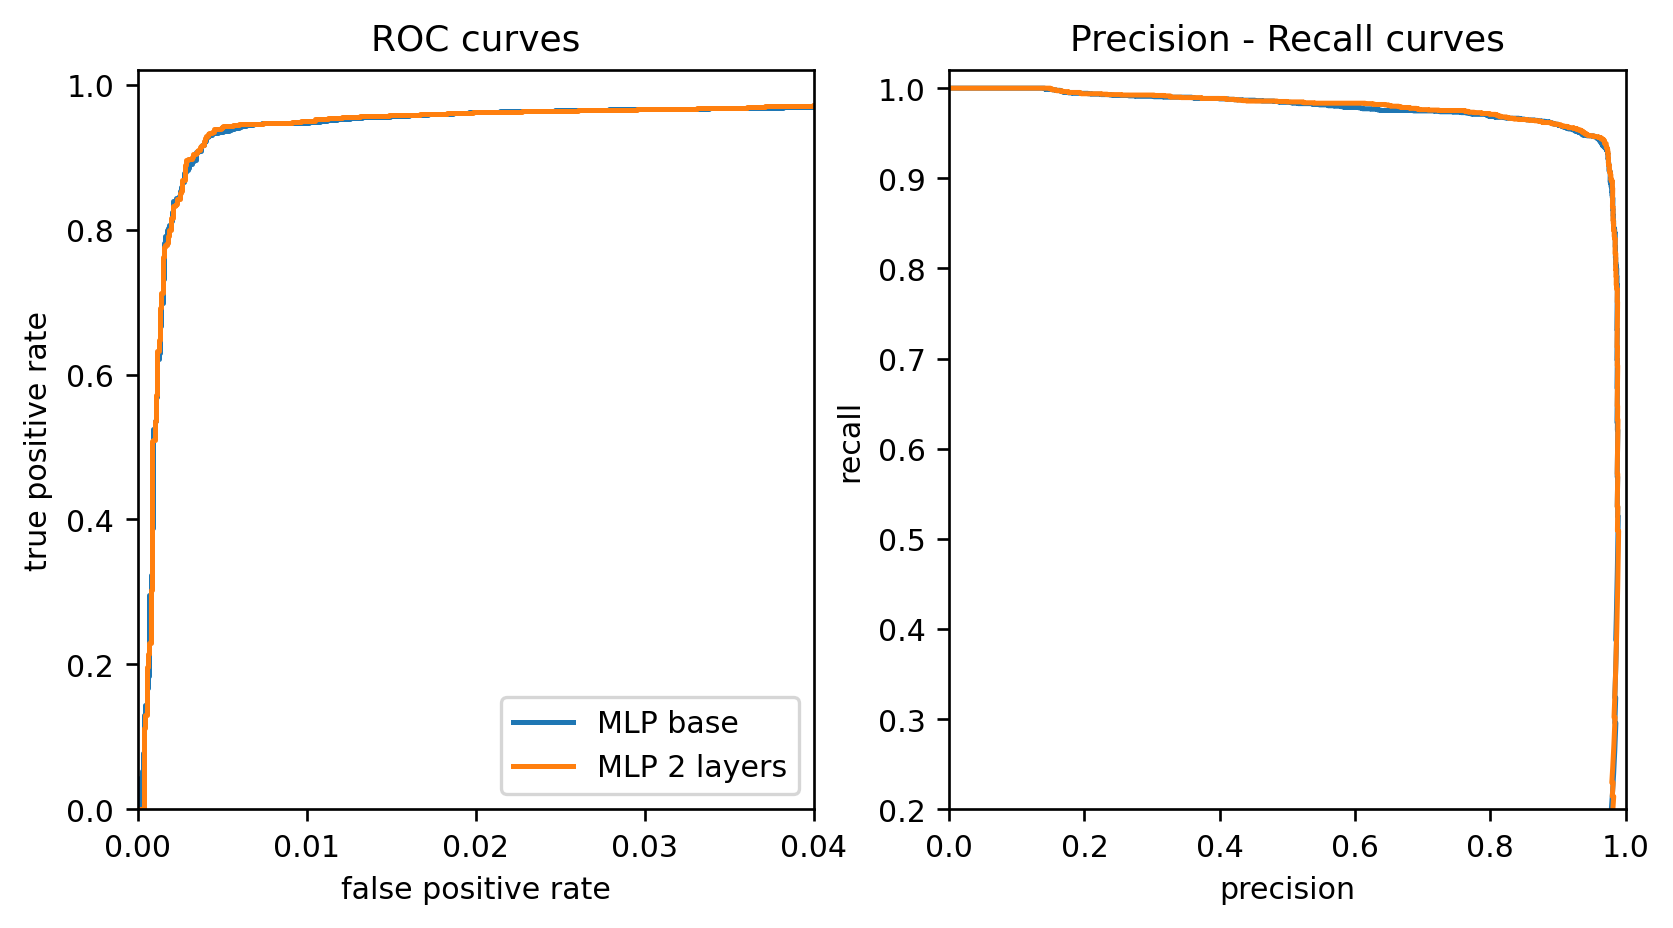

In [80]:
metrics, params = evaluate_classifiers(classifiers_d)

In [ ]:
info_list = [info_base, info_2layers]